image : DataTraining\PlatNomor\platnomor (1).jpg

0: 416x640 1 person, 5 cars, 243.7ms
Speed: 2.6ms preprocess, 243.7ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 (no detections), 61.8ms
Speed: 3.1ms preprocess, 61.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 62.3ms
Speed: 3.0ms preprocess, 62.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 licenses, 67.7ms
Speed: 2.7ms preprocess, 67.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 license, 67.2ms
Speed: 2.7ms preprocess, 67.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


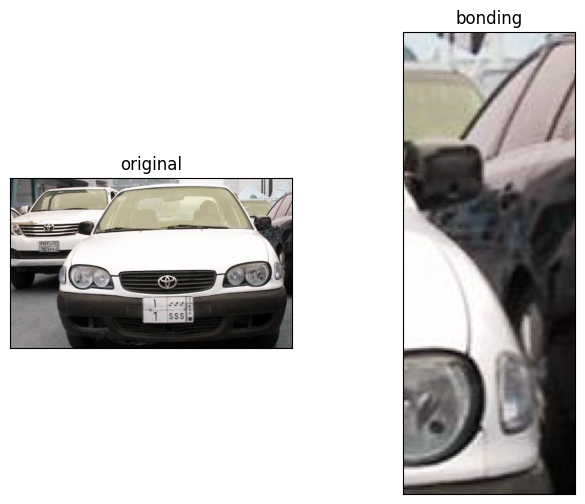

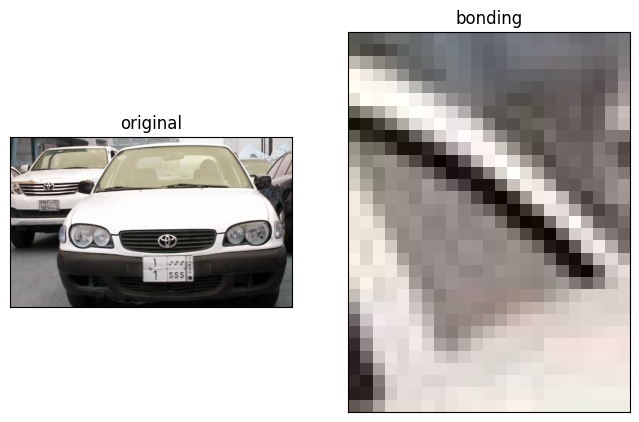

In [9]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np
from datetime import datetime
import os
import glob
from Model.imageProcess import f_image_read, f_image_preprocessing_010, f_save_image, f_imagesingle_read, f_image_box, f_image_box_license, f_image_box_license_2
from Model.sqlProcess import f_sql_object_detection
from Model.ocrProcess import f_ocr_process


yolo_model = "yolov10m.pt"
YoloModelVehicle = YOLO(f"Yolo/{yolo_model}")
YoloModelLicenseNumber = YOLO("Yolo/best.pt")
# Dapatkan mapping dari ID kelas ke nama kelas
class_names = YoloModelVehicle.names

# print(f"vehicle_results : {YoloModelVehicle.names}")

image_folder = 'DataTraining\PlatNomor'
image_files = glob.glob(os.path.join(image_folder, '*.jpg'))

for image in image_files:
    tanggal_start = datetime.today()
    print(f"image : {image}")

    frame = cv2.imread(image)

    vehicle_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    original_frame = frame.copy()

    # Deteksi kendaraan
    vehicle_results = YoloModelVehicle(frame)

    # print(f"vehicle_results : {vehicle_results}")
    for vehicle in vehicle_results:
        # print(f"vehicle : {vehicle.boxes}")
        for box in vehicle.boxes:
            # print(f"box : {box}")

            x1, y1, x2, y2 = map(int, box.xyxy[0].numpy())
            class_id = int(box.cls[0])
            confidence = box.conf[0]

            if class_id in [2, 3, 5, 7] and confidence > 0.50:
                vehicle_crop = frame[y1:y2, x1:x2]
                vh, vw = vehicle_crop.shape[:2]
                vehicle_crop_resized = cv2.resize(vehicle_crop, (640, 640))

                license_plate_results = YoloModelLicenseNumber(vehicle_crop_resized)

                for result in license_plate_results:
                    for lp_box in result.boxes:
                        lx1, ly1, lx2, ly2 = map(int, lp_box.xyxy[0].numpy())
                        lp_conf = lp_box.conf[0]

                        if lp_conf > 0.5:
                            scale_x = vw / 640
                            scale_y = vh / 640
                            lx1 = int(lx1 * scale_x)
                            lx2 = int(lx2 * scale_x)
                            ly1 = int(ly1 * scale_y)
                            ly2 = int(ly2 * scale_y)

                            abs_lx1 = lx1 + x1
                            abs_lx2 = lx2 + x1
                            abs_ly1 = ly1 + y1
                            abs_ly2 = ly2 + y1

                            license_crop = original_frame[abs_ly1:abs_ly2, abs_lx1:abs_lx2]                        

                            frame = f_image_box(license_crop, abs_lx1, abs_lx2, abs_ly1, abs_ly2, "")

                            f_image_read(image1=original_frame, title1="original", image2=frame, title2="bonding")

                            cv2.imwrite(filename=f"DataTraining/PlatNomorResult/{frame}-oke.jpeg",
                                                img=frame)